In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CamembertTokenizer, CamembertModel
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

# Mapping des labels
label_mapping = {"Entrée": 0, "Plat principal": 1, "Dessert": 2}
df_train["label"] = df_train["type"].map(label_mapping)
df_test["label"] = df_test["type"].map(label_mapping)

# Fusionner les textes
df_train["text"] = df_train["titre"] + " " + df_train["ingredients"] + " " + df_train["recette"]
df_test["text"] = df_test["titre"] + " " + df_test["ingredients"] + " " + df_test["recette"]


In [2]:
# Charger Camembert et Tokenizer
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model_bert = CamembertModel.from_pretrained("camembert-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

# Fonction pour encoder les textes et retourner input_ids et attention_mask
def encode_texts(texts, tokenizer, batch_size=16):
    input_ids = []
    attention_masks = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encoding = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        
        input_ids.append(encoding["input_ids"])
        attention_masks.append(encoding["attention_mask"])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Encoder les textes pour l'entraînement et le test
X_train_input_ids, X_train_attention_mask = encode_texts(df_train["text"].tolist(), tokenizer)
X_test_input_ids, X_test_attention_mask = encode_texts(df_test["text"].tolist(), tokenizer)

# Labels
y_train = torch.tensor(df_train["label"].values, dtype=torch.long)
y_test = torch.tensor(df_test["label"].values, dtype=torch.long)


In [3]:
class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_classes=3):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state.mean(dim=1)  # Moyenne des embeddings
        output = self.dropout(pooled_output)
        return self.fc(output)

# Créer et déplacer le modèle sur le bon appareil (CPU/GPU)
model = BertClassifier(model_bert).to(device)


In [ ]:
# Fonction d'entraînement du modèle
def train_model(model, X_train_input_ids, X_train_attention_mask, y_train, epochs=5, batch_size=16):
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i in range(0, len(X_train_input_ids), batch_size):
            input_ids = X_train_input_ids[i:i+batch_size].to(device)
            attention_mask = X_train_attention_mask[i:i+batch_size].to(device)
            labels = y_train[i:i+batch_size].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Époque {epoch + 1}, Perte Moyenne: {total_loss / len(X_train_input_ids):.4f}")

# Entraînement du modèle
train_model(model, X_train_input_ids, X_train_attention_mask, y_train, epochs=5, batch_size=16)


In [5]:
# Charger le modèle Camembert
model_bert = CamembertModel.from_pretrained("camembert-base")
model = BertClassifier(model_bert).to(device)

# Charger les poids pré-entraînés
model.load_state_dict(torch.load("bert_epoch_10.pth", map_location=device))
model.eval()  # Mettre le modèle en mode évaluation si tu ne veux pas faire d'entraînement


BertClassifier(
  (bert): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

📊 **Rapport de classification** :
              precision    recall  f1-score   support

      Entrée       0.70      0.78      0.74       337
        Plat       0.88      0.83      0.85       644
     Dessert       0.99      0.99      0.99       407

    accuracy                           0.86      1388
   macro avg       0.86      0.86      0.86      1388
weighted avg       0.87      0.86      0.86      1388



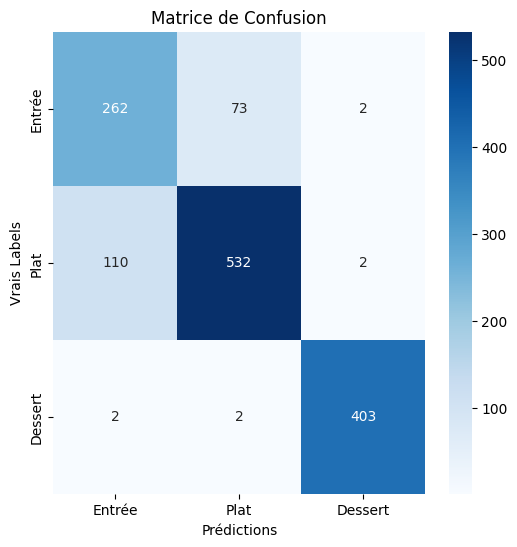

In [6]:
# Fonction d'évaluation du modèle et calcul du F1-score + Matrice de confusion
def evaluate_with_metrics(model, X_test_input_ids, X_test_attention_mask, y_test):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        outputs = model(X_test_input_ids.to(device), X_test_attention_mask.to(device))
        predictions = torch.argmax(outputs, dim=1)
        all_labels.extend(y_test.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

    # Calcul du F1-score
    print("📊 **Rapport de classification** :")
    print(classification_report(all_labels, all_predictions, target_names=['Entrée', 'Plat', 'Dessert']))

    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Entrée', 'Plat', 'Dessert'], yticklabels=['Entrée', 'Plat', 'Dessert'])
    plt.xlabel("Prédictions")
    plt.ylabel("Vrais Labels")
    plt.title("Matrice de Confusion")
    plt.show()

# Évaluation complète
evaluate_with_metrics(model, X_test_input_ids, X_test_attention_mask, y_test)
